# Customer RFM Segmentation
Customer segmentation used to target shipping cost voucher receiver candidate. As stated on my analysis before, the use of voucher doesn't seem to have any effect on user's satisfaction. However, this strategy may be able to increase user retention. Since the majority of users only order at most 2 times in the span of 2 years this is a severe problem for the ecommerce. Therefore a strategy needed to be laid out to increase user transaction frequency and monetary value.

## Free Shipping Voucher Strategy
Shipping cost voucher will be awarded to customer which has lower transaction frequency but relatively higher monetary value. Not only that, but customer will be able to use the voucher only after it fulfill some conditions such as minimum transaction value, applied only to Official Store, or on certain occassion or date.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# import postgres connection factory utility
from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.128.0.2',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
customer_rfm_query = """SELECT 
	ud.user_sk,
	mcmv.total_spending,
	mcmv.total_shipping_cost,
	mcof.count_order,
	EXTRACT(epoch FROM mcr.last_order_interval/86400)::int8 AS last_order_days
FROM 
	warehouse.user_dim ud 
LEFT JOIN warehouse.mart_customer_monetary_value mcmv ON
	ud.user_sk = mcmv.user_sk
LEFT JOIN warehouse.mart_customer_order_frequency mcof ON
	ud.user_sk = mcof.user_sk
LEFT JOIN warehouse.mart_customer_recency mcr ON
	ud.user_sk = mcr.user_sk;"""
customer_rfm = pd.read_sql(customer_rfm_query, con=postgres_conn)
display(customer_rfm.info())
display(customer_rfm.head(5))
display(customer_rfm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96097 entries, 0 to 96096
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_sk              96097 non-null  int64  
 1   total_spending       94983 non-null  float64
 2   total_shipping_cost  94983 non-null  float64
 3   count_order          94990 non-null  float64
 4   last_order_days      94990 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.7 MB


None

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
0,4,75900.0,15280.0,1.0,470.0
1,6,29990.0,16110.0,1.0,429.0
2,7,19990.0,7390.0,1.0,177.0
3,8,14990.0,7780.0,1.0,279.0
4,11,1200000.0,37810.0,1.0,415.0


,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
count,96097.000000,9.498300e+04,9.498300e+04,94990.000000,94990.000000
mean,48047.999990,1.420748e+05,2.359620e+04,1.033867,288.349479
std,27740.958764,2.160760e+05,2.287058e+04,0.210826,153.000542
min,-1.000000,8.500000e+02,0.000000e+00,1.000000,45.000000
25%,24024.000000,4.790000e+04,1.409000e+04,1.000000,164.000000
50%,48048.000000,8.989000e+04,1.760000e+04,1.000000,269.000000
75%,72072.000000,1.550000e+05,2.554000e+04,1.000000,397.000000
max,96096.000000,1.344000e+07,1.794960e+06,16.000000,774.000000


### Check for Null Value

In [5]:
customer_rfm.isnull().sum()

user_sk                   0
total_spending         1114
total_shipping_cost    1114
count_order            1107
last_order_days        1107
dtype: int64

## Exploratory Data Analysis

### Order Frequency

,count_order,user_sk
0,1.0,92102
1,2.0,2652
2,3.0,188
3,4.0,29
4,5.0,9
5,6.0,5
6,7.0,3
7,9.0,1
8,16.0,1


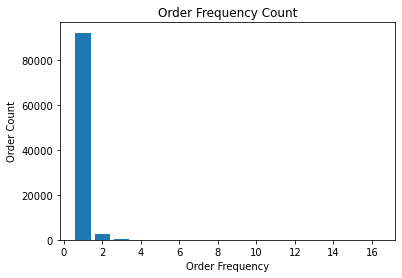

In [6]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_sk', 'count_order']] \
        .groupby('count_order', as_index=False).count()
ax.bar(t1['count_order'], t1['user_sk'])
ax.set_title('Order Frequency Count')
ax.set_xlabel('Order Frequency')
ax.set_ylabel('Order Count')

display(t1)
plt.show()

### Order Recency

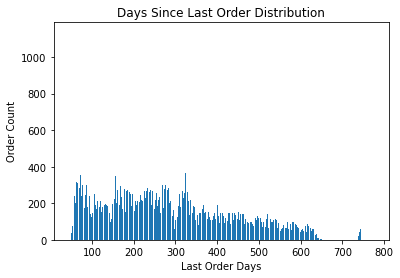

,days_since_last_order,count_order
0,45.0,1
1,50.0,11
2,51.0,39
3,52.0,66
4,53.0,73
5,54.0,69
6,55.0,96
7,56.0,142
8,57.0,184
9,58.0,239


In [7]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_sk', 'last_order_days']] \
        .groupby('last_order_days', as_index=False).count()
ax.bar(t1['last_order_days'], t1['user_sk'])
ax.set_title('Days Since Last Order Distribution')
ax.set_xlabel('Last Order Days')
ax.set_ylabel('Order Count')

plt.show()
t1.columns = ['days_since_last_order', 'count_order']
display(t1.head(15))

### Monetary Value

In [8]:
customer_rfm

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
0,4,75900.0,15280.0,1.0,470.0
1,6,29990.0,16110.0,1.0,429.0
2,7,19990.0,7390.0,1.0,177.0
3,8,14990.0,7780.0,1.0,279.0
4,11,1200000.0,37810.0,1.0,415.0
...,...,...,...,...,...
96092,96091,29000.0,15100.0,1.0,276.0
96093,96092,299900.0,14400.0,1.0,62.0
96094,96093,208000.0,39510.0,1.0,156.0
96095,96095,969990.0,51250.0,1.0,472.0


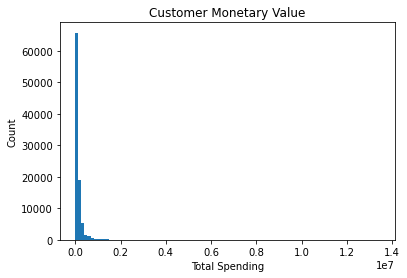

In [9]:
fig, ax = plt.subplots()

ax.hist(customer_rfm['total_spending'], bins=100)
ax.set_title('Customer Monetary Value')
ax.set_xlabel('Total Spending')
ax.set_ylabel('Count')

plt.show()

,monetary_value,user_sk
0,0.0,966
1,1.0,934
2,2.0,1048
3,3.0,865
4,4.0,948
...,...,...
93,93.0,951
94,94.0,940
95,95.0,953
96,96.0,947


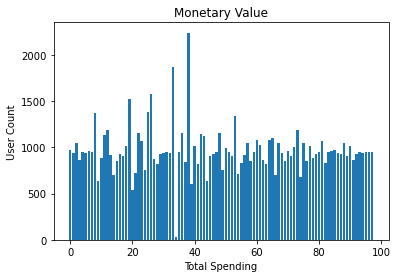

In [10]:
fig, ax = plt.subplots()

t0 = customer_rfm.copy()

t0['monetary_value'] = pd.qcut(customer_rfm['total_spending'], q=100, labels=False, duplicates='drop')
t1 = t0.loc[:, ['user_sk', 'monetary_value']] \
        .groupby('monetary_value', as_index=False).count()
ax.bar(t1['monetary_value'], t1['user_sk'])
ax.set_title('Monetary Value')
ax.set_xlabel('Total Spending')
ax.set_ylabel('User Count')

display(t1)
plt.show()

## Baseline Model
Manually assigned RFM score based on percentile.
<table>
    <tr>
        <th>Recency</th>
        <th>Frequency</th>
        <th>Monetary</th>
    </tr>
    <tr>
        <td>R-Tier-1 (most recent)</td>
        <td>F-Tier-1 (most frequent)</td>
        <td>M-Tier-1 (highest spend)</td>
    </tr>
    <tr>
        <td>R-Tier-2</td>
        <td>F-Tier-2</td>
        <td>M-Tier-2</td>
    </tr>
    <tr>
        <td>R-Tier-3</td>
        <td>F-Tier-3</td>
        <td>M-Tier-3</td>
    </tr>
    <tr>
        <td>R-Tier-4 (least recent)</td>
        <td>F-Tier-4 (least frequent)</td>
        <td>M-Tier-4 (lowest spend)</td>
    </tr>
</table>
Reiterating the goals again, the strategy prefer customer which has lower frequency but relatively higher monetary value. Below are the segment name assignment based on customer RFM score:<br>
<table>
<thead>
  <tr>
    <th>R</th>
    <th>F</th>
    <th>M</th>
    <th>Customer Segment</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1-2</td>
    <td>1-4</td>
    <td>1-2</td>
    <td>High-spending Active Customer **</td>
  </tr>
  <tr>
    <td>1-2</td>
    <td>1-4</td>
    <td>3-4</td>
    <td>Low-spending Active Customer *</td>
  </tr>
  <tr>
    <td>3-4</td>
    <td>1-4</td>
    <td>1-2</td>
    <td>Churned High-spending Customer **</td>
  </tr>
  <tr>
    <td>3-4</td>
    <td>1-4</td>
    <td>3-4</td>
    <td>Churned Low-spending Customer *</td>
  </tr>
</tbody>
</table>
<b>Note:</b><br>
** The best candidate to receive free shipping voucher is marked with double asterisk<br>
* The second best candidate is marked with single asterisk

In [11]:
rfm = customer_rfm.copy()
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96097 entries, 0 to 96096
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_sk              96097 non-null  int64  
 1   total_spending       94983 non-null  float64
 2   total_shipping_cost  94983 non-null  float64
 3   count_order          94990 non-null  float64
 4   last_order_days      94990 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.7 MB


### Drop Null Values

In [12]:
rfm = rfm.dropna()
rfm.isnull().sum()

user_sk                0
total_spending         0
total_shipping_cost    0
count_order            0
last_order_days        0
dtype: int64

## Assign RFM Tier

### Recency Tier

,recency_tier,user_sk
0,1,23796
1,2,23815
2,3,23645
3,4,23727


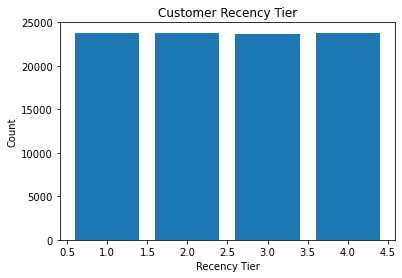

In [13]:
rfm['recency_tier'] = pd.qcut(rfm['last_order_days'], q=4, labels=range(1, 5))

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_sk', 'recency_tier']] \
        .groupby('recency_tier', as_index=False).count()
ax.bar(t1['recency_tier'], t1['user_sk'])
ax.set_title('Customer Recency Tier')
ax.set_xlabel('Recency Tier')
ax.set_ylabel('Count')

display(t1)
plt.show()

### Frequency Tier

,frequency_tier,user_sk
0,1,19
1,2,217
2,3,2652
3,4,92095


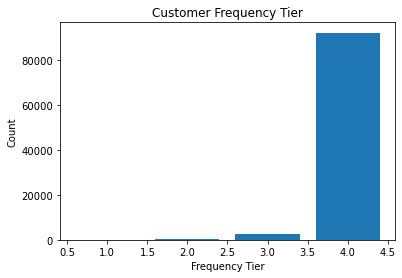

In [14]:
rfm.loc[(rfm['count_order'] >= 5) & (rfm['count_order'] <= 16), 'frequency_tier'] = 1
rfm.loc[(rfm['count_order'] >= 3) & (rfm['count_order'] <= 4), 'frequency_tier'] = 2
rfm.loc[rfm['count_order'] == 2, 'frequency_tier'] = 3
rfm.loc[rfm['count_order'] == 1, 'frequency_tier'] = 4

rfm['frequency_tier'] = rfm['frequency_tier'].astype('int')

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_sk', 'frequency_tier']] \
        .groupby('frequency_tier', as_index=False).count()
ax.bar(t1['frequency_tier'], t1['user_sk'])
ax.set_title('Customer Frequency Tier')
ax.set_xlabel('Frequency Tier')
ax.set_ylabel('Count')

display(t1)
plt.show()

### Monetary Tier

,monetary_tier,user_sk
0,4,23878
1,3,23617
2,2,23797
3,1,23691


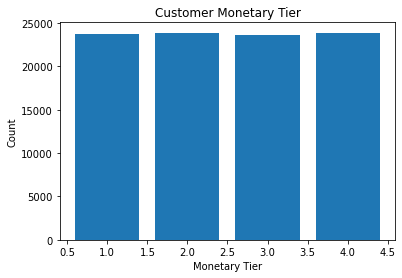

In [15]:
# cek pake selain pd.cut
rfm['monetary_tier'] = pd.qcut(rfm['total_spending'], q=4, labels=range(4, 0, -1))

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_sk', 'monetary_tier']] \
        .groupby('monetary_tier', as_index=False).count()
ax.bar(t1['monetary_tier'], t1['user_sk'])
ax.set_title('Customer Monetary Tier')
ax.set_xlabel('Monetary Tier')
ax.set_ylabel('Count')

display(t1)
plt.show()

In [16]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94983 entries, 0 to 96096
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   user_sk              94983 non-null  int64   
 1   total_spending       94983 non-null  float64 
 2   total_shipping_cost  94983 non-null  float64 
 3   count_order          94983 non-null  float64 
 4   last_order_days      94983 non-null  float64 
 5   recency_tier         94983 non-null  category
 6   frequency_tier       94983 non-null  int64   
 7   monetary_tier        94983 non-null  category
dtypes: category(2), float64(4), int64(2)
memory usage: 5.3 MB


## Distribution of RFM Tier

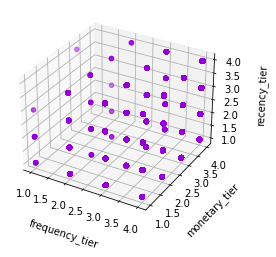

In [17]:
rfm_scatter = rfm.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = rfm_scatter.loc[:, 'frequency_tier']
ys = rfm_scatter.loc[:, 'monetary_tier']
zs = rfm_scatter.loc[:, 'recency_tier']

ax.scatter(xs, ys, zs, c='darkviolet')

ax.set_xlabel('\nfrequency_tier', linespacing=2.0)
ax.set_ylabel('\nmonetary_tier', linespacing=2.0)
ax.set_zlabel('\nrecency_tier', linespacing=2.0)

plt.show()

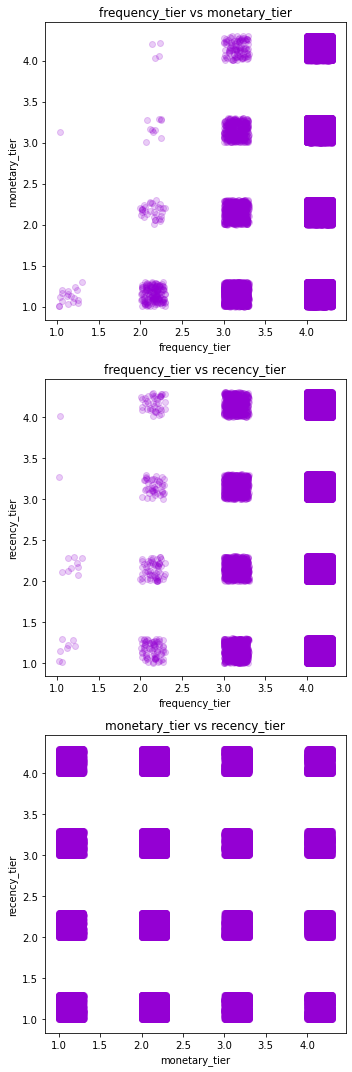

In [18]:
tt1 = rfm.copy()
tt1['frequency_tier'] = tt1.apply(lambda row: row['frequency_tier']+(np.random.rand()*0.3), axis=1)
tt1['monetary_tier'] = tt1.apply(lambda row: row['monetary_tier']+(np.random.rand()*0.3), axis=1)
tt1['recency_tier'] = tt1.apply(lambda row: row['recency_tier']+(np.random.rand()*0.3), axis=1)

t = ['frequency_tier', 'monetary_tier', 'recency_tier']
c = []
f = []

for i in range(0, len(t)):
    for j in range(0, len(t)):
        t0 = t[i]
        t1 = t[j]
        
        if t0 == t1:
            continue
        
        if [t0, t1] in c:
            continue
        else:
            f.append([t0, t1])
            c.append([t0, t1])
            c.append([t1, t0])

fig, axs = plt.subplots(len(f), 1)
fig.set_size_inches(5, 15, forward=True)

for i in range(0, len(f)):
    ax = axs[i]
    ax.scatter(tt1[f[i][0]], tt1[f[i][1]], alpha=0.2, c='darkviolet')
    ax.set_title('{} vs {}'.format(f[i][0], f[i][1]))
    ax.set_xlabel(f[i][0])
    ax.set_ylabel(f[i][1])

plt.tight_layout()
plt.show()

## Customer Segmentation

### High Spending Active Customer

In [19]:
high_spending_active_cust_cond = \
    (rfm['recency_tier'] <= 2) \
    & (rfm['monetary_tier'] >= 2)

high_spending_active_cust = rfm[high_spending_active_cust_cond]
display(high_spending_active_cust.head(10))
display(high_spending_active_cust.shape)

rfm.loc[high_spending_active_cust_cond, 'customer_segment'] = 'hsac'

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days,recency_tier,frequency_tier,monetary_tier
9,39,115000.0,15690.0,1.0,206.0,2,4,2
11,45,274000.0,33310.0,1.0,157.0,1,4,1
13,55,524900.0,17760.0,1.0,169.0,2,4,1
20,81,522500.0,26530.0,1.0,260.0,2,4,1
39,155,569900.0,60540.0,1.0,135.0,1,4,1
45,193,449000.0,84450.0,1.0,71.0,1,4,1
47,203,314900.0,14860.0,1.0,112.0,1,4,1
51,210,110320.0,8030.0,1.0,121.0,1,4,2
52,215,249990.0,14050.0,1.0,83.0,1,4,1
54,224,199900.0,13700.0,1.0,66.0,1,4,1


(24043, 8)

### Low Spending Active Customer

In [20]:
low_spending_active_cust_cond = \
    (rfm['recency_tier'] <= 2) \
    & (rfm['monetary_tier'] <= 3)

low_spending_active_cust = rfm[low_spending_active_cust_cond]
display(low_spending_active_cust.head(10))
display(low_spending_active_cust.shape)

rfm.loc[low_spending_active_cust_cond, 'customer_segment'] = 'lsac'

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days,recency_tier,frequency_tier,monetary_tier,customer_segment
2,7,19990.0,7390.0,1.0,177.0,2,4,4,NaN
8,31,54000.0,16630.0,1.0,248.0,2,4,3,NaN
14,58,67990.0,19820.0,1.0,213.0,2,4,3,NaN
15,65,62000.0,18010.0,1.0,167.0,2,4,3,NaN
16,67,69900.0,12430.0,1.0,153.0,1,4,3,NaN
21,86,28990.0,18300.0,1.0,128.0,1,4,4,NaN
30,129,13650.0,7390.0,1.0,222.0,2,4,4,NaN
31,131,63990.0,18030.0,1.0,165.0,2,4,3,NaN
32,134,87900.0,17870.0,1.0,228.0,2,4,3,NaN
42,176,23990.0,15270.0,1.0,100.0,1,4,4,NaN


(23568, 9)

### Churned High Spending Customer

In [21]:
churned_high_spending_cust_cond = \
    (rfm['recency_tier'] >= 3) \
    & (rfm['monetary_tier'] >= 2)

churned_high_spending_cust = rfm[churned_high_spending_cust_cond]
display(churned_high_spending_cust.head(10))
display(churned_high_spending_cust.shape)

rfm.loc[churned_high_spending_cust_cond, 'customer_segment'] = 'chsc'

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days,recency_tier,frequency_tier,monetary_tier,customer_segment
4,11,1200000.0,37810.0,1.0,415.0,4,4,1,NaN
5,13,119900.0,23160.0,1.0,322.0,3,4,2,NaN
6,18,210000.0,28020.0,1.0,278.0,3,4,1,NaN
7,24,109990.0,17510.0,1.0,622.0,4,4,2,NaN
12,53,131170.0,13260.0,1.0,500.0,4,4,2,NaN
17,71,107000.0,12250.0,1.0,282.0,3,4,2,NaN
18,73,169990.0,16400.0,1.0,570.0,4,4,1,NaN
19,79,140900.0,26270.0,1.0,525.0,4,4,2,NaN
22,91,209990.0,53480.0,1.0,470.0,4,4,1,NaN
23,93,173420.0,27750.0,1.0,421.0,4,4,1,NaN


(23445, 9)

### Churned Low Spending Customer

In [22]:
churned_low_spending_cust_cond = \
    (rfm['recency_tier'] >= 3) \
    & (rfm['monetary_tier'] <= 3)

churned_low_spending_cust = rfm[churned_low_spending_cust_cond]
display(churned_low_spending_cust.head(10))
display(churned_low_spending_cust.shape)

rfm.loc[churned_low_spending_cust_cond, 'customer_segment'] = 'clsc'

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days,recency_tier,frequency_tier,monetary_tier,customer_segment
0,4,75900.0,15280.0,1.0,470.0,4,4,3,NaN
1,6,29990.0,16110.0,1.0,429.0,4,4,4,NaN
3,8,14990.0,7780.0,1.0,279.0,3,4,4,NaN
10,42,25900.0,25630.0,1.0,359.0,3,4,4,NaN
25,102,31000.0,20400.0,1.0,553.0,4,4,4,NaN
26,108,51920.0,12700.0,1.0,421.0,4,4,3,NaN
27,114,26900.0,15100.0,1.0,420.0,4,4,4,NaN
33,137,25600.0,16110.0,1.0,384.0,3,4,4,NaN
36,148,89000.0,17870.0,1.0,291.0,3,4,3,NaN
41,166,39900.0,15100.0,1.0,526.0,4,4,4,NaN


(23927, 9)

### Check Segment For All Customer

Make sure all customer is segmented

In [23]:
rfm.isnull().sum()

user_sk                0
total_spending         0
total_shipping_cost    0
count_order            0
last_order_days        0
recency_tier           0
frequency_tier         0
monetary_tier          0
customer_segment       0
dtype: int64

### Base Model Cluster Result

In [24]:
rfm['recency_tier'] = pd.factorize(rfm['recency_tier'], sort=True)[0] + 1
rfm['monetary_tier'] = 4 - rfm['monetary_tier'].astype('category').cat.codes

In [25]:
def enc_cust_segment(row):
    segment = ['hsac', 'lsac', 'chsc', 'clsc']
    return segment.index(row['customer_segment'])

rfm['customer_segment_code'] = rfm.apply(lambda row: enc_cust_segment(row), axis=1)

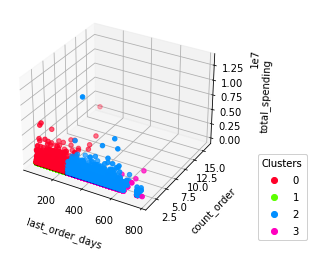

In [26]:
base_df = rfm.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = base_df.loc[:, 'last_order_days']
ys = base_df.loc[:, 'count_order']
zs = base_df.loc[:, 'total_spending']
y = base_df.loc[:, 'customer_segment_code']

axscatter = ax.scatter(xs, ys, zs, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('\nlast_order_days', linespacing=2.0)
ax.set_ylabel('\ncount_order', linespacing=2.0)
ax.set_zlabel('\ntotal_spending', linespacing=3.1)

plt.show()

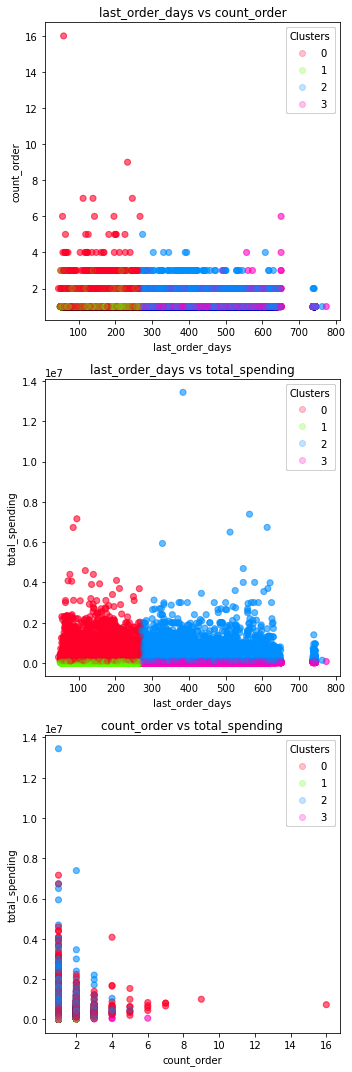

In [27]:
def add_random_noise(s, noise_strength=0.5):
    np.random.seed(np.random.randint(1, len(s)))
    noise = [np.random.rand() * (np.random.rand() * noise_strength) for i in range(0, len(s))]
    s = s + noise
    return s

rfm_t = rfm.copy()

colors = ['darkviolet', 'limegreen', 'b', 'orange']
segment = ['hsac', 'lsac', 'chsc', 'clsc']

t = ['last_order_days', 'count_order', 'total_spending']
c = []
f = []

for i in range(0, len(t)):
    for j in range(0, len(t)):
        t0 = t[i]
        t1 = t[j]
        
        if t0 == t1:
            continue
        
        if [t0, t1] in c:
            continue
        else:
            f.append([t0, t1])
            c.append([t0, t1])
            c.append([t1, t0])

fig, axs = plt.subplots(len(f), 1)
fig.set_size_inches(5, 15, forward=True)

for i in range(0, len(f)):
    for j in segment:
        ax = axs[i]
        _ttt = rfm_t[rfm_t['customer_segment'] == j]
        axscatter = ax.scatter(rfm_t[f[i][0]], rfm_t[f[i][1]], alpha=0.2, c=y, cmap='gist_rainbow')

        # produce a legend with the unique colors from the scatter
        legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
        
        ax.set_title('{} vs {}'.format(f[i][0], f[i][1]))
        ax.set_xlabel(f[i][0])
        ax.set_ylabel(f[i][1])

plt.tight_layout()
plt.show()

### Baseline Model Evaluation

In [28]:
rfm_eval = rfm.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier', 'customer_segment']]

rfm_eval.loc[rfm_eval['customer_segment'] == 'hsac', 'customer_segment_code'] = 0
rfm_eval.loc[rfm_eval['customer_segment'] == 'lsac', 'customer_segment_code'] = 1
rfm_eval.loc[rfm_eval['customer_segment'] == 'chsc', 'customer_segment_code'] = 2
rfm_eval.loc[rfm_eval['customer_segment'] == 'clsc', 'customer_segment_code'] = 3

# silhouette_score(rfm_eval.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']], \
#                  rfm_eval.loc[:, 'customer_segment_code'])

## Data Preprocessing

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [30]:
df = customer_rfm.copy()
df = df.loc[:, ['last_order_days', 'count_order', 'total_spending']]
df = df.dropna()

In [31]:
minmax = MinMaxScaler()
df = pd.DataFrame(minmax.fit_transform(df))
df.columns = ['last_order_days', 'count_order', 'total_spending']

In [32]:
display(df.head(10))

,last_order_days,count_order,total_spending
0,0.582990,0.0,0.005584
1,0.526749,0.0,0.002168
2,0.181070,0.0,0.001424
3,0.320988,0.0,0.001052
4,0.507545,0.0,0.089228
5,0.379973,0.0,0.008858
6,0.319616,0.0,0.015563
7,0.791495,0.0,0.008121
8,0.278464,0.0,0.003955
9,0.220850,0.0,0.008494


## K-Means

### Using Elbow Method to Get Optimum n-cluster

In [33]:
from sklearn.cluster import KMeans

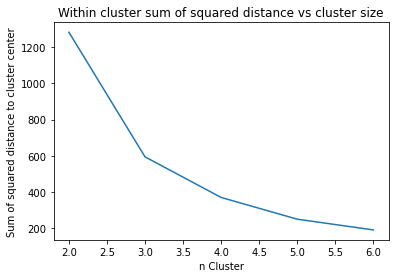

In [34]:
df1 = df.copy()

n_cluster = []
inertia_values = []

for i in range(2,7):
    kmeans = KMeans(n_clusters=i, random_state=111)
    y = kmeans.fit_predict(df1)
    n_cluster.append(i)
    inertia_values.append(kmeans.inertia_)

fig, ax = plt.subplots()

ax.plot(n_cluster, inertia_values)
ax.set_title('Within cluster sum of squared distance vs cluster size')
ax.set_xlabel('n Cluster')
ax.set_ylabel('Sum of squared distance to cluster center')

plt.show()

### Training Model

In [35]:
kmeans = KMeans(n_clusters=4, init='k-means++', tol=0.03)
y = kmeans.fit_predict(df1)

### K-Means Evaluation

In [36]:
sc = silhouette_score(df1, y)
sc

0.5309049144689538

In [37]:
kmeans.inertia_

372.6548723245644

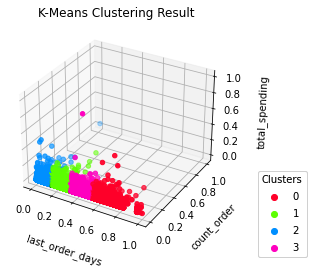

In [38]:
kmeans_df = df.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = kmeans_df.loc[:, 'last_order_days']
ys = kmeans_df.loc[:, 'count_order']
zs = kmeans_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs, ys, zs, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Means Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.3)
ax.set_ylabel('\ncount_order', linespacing=2.3)
ax.set_zlabel('\ntotal_spending', linespacing=2.3)

plt.show()

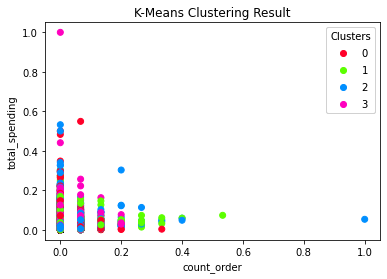

In [39]:
fig, ax = plt.subplots()

xs2 = kmeans_df.loc[:, 'count_order']
ys2 = kmeans_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs2, ys2, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Means Clustering Result')
ax.set_xlabel('count_order')
ax.set_ylabel('total_spending')

plt.show()

## Remove Similar Feature Values

In [36]:
_df = df.copy()

In [37]:
def encode(row):
    return "{:.5f}{:.5f}{:.5f}".format(
            row['last_order_days'],
            row['count_order'],
            row['total_spending'])

In [38]:
_df['_val'] = _df.apply(lambda row: encode(row), axis=1)

In [39]:
_df = _df.drop_duplicates(subset=['_val'])

In [40]:
from sklearn_extra.cluster import KMedoids

In [41]:
_df1 = _df.loc[:, ['last_order_days', 'count_order', 'total_spending']]
_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66883 entries, 0 to 94981
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   last_order_days  66883 non-null  float64
 1   count_order      66883 non-null  float64
 2   total_spending   66883 non-null  float64
dtypes: float64(3)
memory usage: 2.0 MB


## K-Medoids

In [46]:
# n_cluster = []
# inertia_values = []

# for i in range(3,8):
#     kmedoids = KMedoids(n_clusters=i, random_state=111)
#     y = kmedoids.fit_predict(_df1)
#     n_cluster.append(i)
#     inertia_values.append(kmedoids.inertia_)

# fig, ax = plt.subplots()

# ax.plot(n_cluster, inertia_values)
# ax.set_title('Within cluster sum of squared distance vs cluster size')
# ax.set_xlabel('n Cluster')
# ax.set_ylabel('Sum of squared distance to cluster center')

# plt.show()

### Training Model

In [47]:
kmedoids = KMedoids(n_clusters=6, metric='euclidean', init='k-medoids++', method='alternate')
y = kmedoids.fit_predict(_df1)

### K-Medoids Evaluation

In [48]:
sc = silhouette_score(_df1, y, metric='euclidean')
sc

0.49735432131693075

In [49]:
kmedoids.inertia_

2546.333882378474

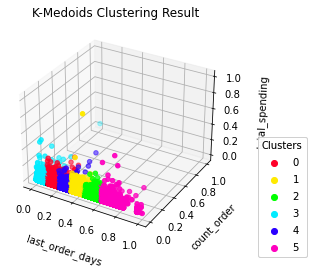

In [50]:
kmedoids_df = _df1.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = _df.loc[:, 'last_order_days']
ys = _df.loc[:, 'count_order']
zs = _df.loc[:, 'total_spending']
axscatter = ax.scatter(xs, ys, zs, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Medoids Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.3)
ax.set_ylabel('\ncount_order', linespacing=2.3)
ax.set_zlabel('\ntotal_spending', linespacing=2.3)

plt.show()

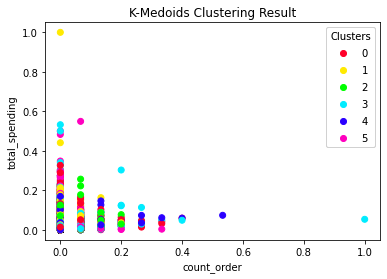

In [51]:
fig, ax = plt.subplots()

xs2 = kmedoids_df.loc[:, 'count_order']
ys2 = kmedoids_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs2, ys2, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Medoids Clustering Result')
ax.set_xlabel('count_order')
ax.set_ylabel('total_spending')

plt.show()

## Hierarchical Clustering

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [42]:
_df2 = _df.copy()
_df2 = _df.loc[:, ['last_order_days', 'count_order', 'total_spending']]
X = _df2.to_numpy()

In [43]:
X.shape

(66883, 3)

### Training Model

In [44]:
Z = linkage(X, method='median', metric='euclidean')

In [ ]:
c, coph_dists = cophenet(Z, pdist(X, metric='euclidean'))
c

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.03,  # plot a horizontal cut-off line
)
plt.show()

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.05,  # plot a horizontal cut-off line
)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.03
clusters = fcluster(Z, max_d, criterion='distance')
clusters

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

axscatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.0)
ax.set_ylabel('\ncount_order', linespacing=2.0)
ax.set_zlabel('\ntotal_spending', linespacing=2.0)

plt.show()

In [ ]:
fig, ax = plt.subplots()

axscatter = ax.scatter(X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('count_order')
ax.set_ylabel('total_spending')

plt.show()

In [ ]:
sc = silhouette_score(X, clusters, metric='euclidean')
sc

### With max_d of 0.05

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.05
clusters = fcluster(Z, max_d, criterion='distance')
clusters

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

axscatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.0)
ax.set_ylabel('\ncount_order', linespacing=2.0)
ax.set_zlabel('\ntotal_spending', linespacing=2.0)

plt.show()

In [ ]:
fig, ax = plt.subplots()

axscatter = ax.scatter(X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('count_order')
ax.set_ylabel('total_spending')

plt.show()

### Hierarchical Clustering Evaluation

In [ ]:
sc = silhouette_score(X, clusters, metric='euclidean')
sc